<a href="https://colab.research.google.com/github/lucguittard/Portolio-Projects/blob/master/DSproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authorize access to G-Drive

In [29]:
#Working from Google Colab, if you downloaded the included merge7.csv to G-drive...
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# if you downloaded merge7.csv locally, you may skip this step 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Work on full dataset

In [0]:
# Import the necessary libraries
# Note: some library imports may be incompatible with Jupyter Notebooks

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import plotly.express as px
from sklearn.metrics import classification_report
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score

In [31]:
# contd.
!pip install category_encoders
!pip install pdpbox
import category_encoders as ce
from sklearn.metrics import r2_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import make_pipeline
from pdpbox import pdp
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate,pdp_interact, pdp_plot, pdp_interact_plot

In [32]:
# contd.
!pip install eli5
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [33]:
# contd.
from sklearn.model_selection import cross_val_score
!pip install category_encoders
!pip install shap 
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

In [0]:
# Read in the merge7.csv file  
dfv = pd.read_csv('/content/drive/My Drive/dsProject2/merge7.csv')
dfv = dfv.drop(columns = ['State', 'County'])

### Split + Data Wrangling


In [36]:
dfv.year.value_counts()

2014    12532
2013    12532
2015    12531
2017    12530
2016    12530
Name: year, dtype: int64

In [37]:
print(dfv.high.isna().sum())
dfv.describe() #search for outliers)

5629


year  ...       metro03
count  62655.000000  ...  62655.000000
mean    2014.999904  ...      0.347618
std        1.414225  ...      0.476218
min     2013.000000  ...      0.000000
25%     2014.000000  ...      0.000000
50%     2015.000000  ...      0.000000
75%     2016.000000  ...      1.000000
max     2017.000000  ...      1.000000

[8 rows x 48 columns]

In [38]:
#holdout test set
test = dfv.query('year == 2017') 
train = dfv.query('year != 2017')

# Split train into train & val

# Split on time-series
re_train = dfv.query('year < 2016')
re_val = dfv.query('year == 2016') #val set approx. 25% of (post- test-split) dataset 
re_test = test
print(re_train.shape,re_val.shape, re_test.shape)

# or split by random
train, test = train_test_split(train, train_size = .8, random_state = 0)
train, val = train_test_split(train, train_size=0.80, random_state=1)
train.shape, val.shape, test.shape

# or use cross-validation...

(37595, 55) (12530, 55) (12530, 55)


((32080, 55), (8020, 55), (10025, 55))

In [0]:
train.isna().sum()

In [0]:
train.nunique()

In [0]:
# Wrangle the split sets -- using same fxn, one for both methods of splitting.
#  Time-based split train set still contains variability in the 'year' feature.

def wrangle(X):    
    X = X.copy()
    
    #keep important features  
    X = X[['NetMigrationRate1018','Economic Types Type_2015_Update non-overlapping',
           'Low_Education_2015_update','PctVetsPoor','RuralUrbanContinuumCode2013',
           'MedHHInc','high', 'qtr', 'FIPS','year','low'
          ]]
    
    #managing outliers
    X = X.query('MedHHInc < 70000')
    #X = X.query('PerCapitaInc < 45000')
    #X = X.query('PovertyUnder18Pct < 40')
    #X = X.query('PovertyAllAgesPct < 35')
    #X = X.query('Deep_Pov_All < 18')
    
    
    #feat/engineering
    X = X.drop(columns=['high']) #column of (many) nan
    X = X.query('qtr == 4')
    
    # Drop duplicate columns --> none yet
    duplicates = []
    X = X.drop(columns=duplicates)
    
    #drop unusable variances
    unusable_variance = ['FIPS','year','qtr']
    X = X.drop(columns=unusable_variance)
    
    #bin the y-continuous feat using qcut to account for left-ward skew
    #X['debt_class'] = pd.cut(X['low'],8,labels = False) 
    X['debt_class'] = pd.qcut((list(X['low'])), 6, labels = False)
    X = X.drop(columns = 'low')
    
    #drop any remaining rows/entries containing one or more nan
    X = X.dropna()
    
    # return the wrangled dataframe
    return X
  
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
re_train = wrangle(re_train)
re_val = wrangle(re_val)
re_test = wrangle(re_test)

In [0]:
# Further engineering
target = 'debt_class'

train_features = train.drop(columns=[target])
re_train_features = re_train.drop(columns = [target])

# list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
re_numeric_features = re_train_features.select_dtypes(include='number').columns.tolist()

# series with cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
re_cardinality = re_train_features.select_dtypes(exclude='number').nunique()

# list of categorical features w/cardinality <= 25
categorical_features = cardinality[cardinality <= 50].index.tolist() #none w/wrangle2 function; all w/cards in 1000s
re_categorical_features = re_cardinality[re_cardinality <= 10].index.tolist()

features = numeric_features + categorical_features
re_features = re_numeric_features + categorical_features

In [0]:
# Define X and y subsets

target = 'debt_class'
# features = numeric_features + categorical_features
features = ['NetMigrationRate1018','Economic Types Type_2015_Update non-overlapping',
            'Low_Education_2015_update','PctVetsPoor','RuralUrbanContinuumCode2013',
            'MedHHInc']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

re_X_train = re_train[features]
re_y_train = re_train[target]
re_X_val = re_val[features]
re_y_val = re_val[target]

X_test = test[features]
y_test = test[target]

# X_train = train[features]
# y_train = train[target]
# X_val = val[features]
# y_val = val[target]

# re_X_train = re_train[re_features]
# re_y_train = re_train[target]
# re_X_val = re_val[re_features]
# re_y_val = re_val[target]

# X_test = test[features]
# y_test = test[target]

### Exploratory visuals

In [0]:
train['debt_class'].value_counts() # not insignificant left-ward skew -> fix via use of qcut

0    1740
2    1546
3    1480
5    1087
1     801
4     696
Name: debt_class, dtype: int64

In [0]:
px.scatter(train, x="NetMigrationRate1018", y="debt_class", trendline="ols", opacity = .06)

### Split Baseline + Dist Plot + Confusion Matrix

In [0]:
#baseline

y_train.value_counts(normalize=True)  #baseline = .237 (for class 0 of 6)

0    0.236735
2    0.210340
3    0.201361
5    0.147891
1    0.108980
4    0.094694
Name: debt_class, dtype: float64

In [0]:
#dist plot

hist_data = [y_train]
group_labels = ['low debt rates groupings'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

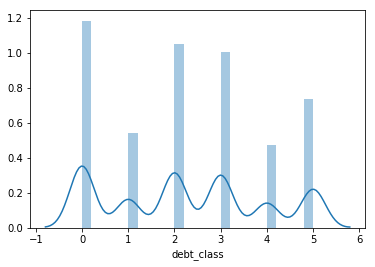

In [0]:
sns.distplot(y_train);

In [0]:
#Accuracy score for baseline
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred) 

0.2162752594210814

In [0]:
#precision and recall for model/majority class baseline
#confusion matrix used for multi-class. types
print(classification_report(y_val, y_pred)) 

              precision    recall  f1-score   support

           0       0.22      1.00      0.36       396
           1       0.00      0.00      0.00       404
           2       0.00      0.00      0.00       204
           3       0.00      0.00      0.00       392
           4       0.00      0.00      0.00       168
           5       0.00      0.00      0.00       267

    accuracy                           0.22      1831
   macro avg       0.04      0.17      0.06      1831
weighted avg       0.05      0.22      0.08      1831



### PDP Plots

In [0]:
#Fit a model
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.3154531361688153


In [0]:
feature = 'NetMigrationRate1018'
isolated = pdp_isolate(model = gb, dataset = X_val, model_features = X_val.columns,
                       feature=feature)

plt.rcParams['figure.dpi'] =  80
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=10)
plt.xlim(0,12)
plt.ylim(-2,12);

# need to assume a class/cat approach
# interpretation: as PctEmpConstruction inc. so too does the absolute impact it has on 
# the predicted outcome 

In [0]:
#PDP of Categorical feats

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

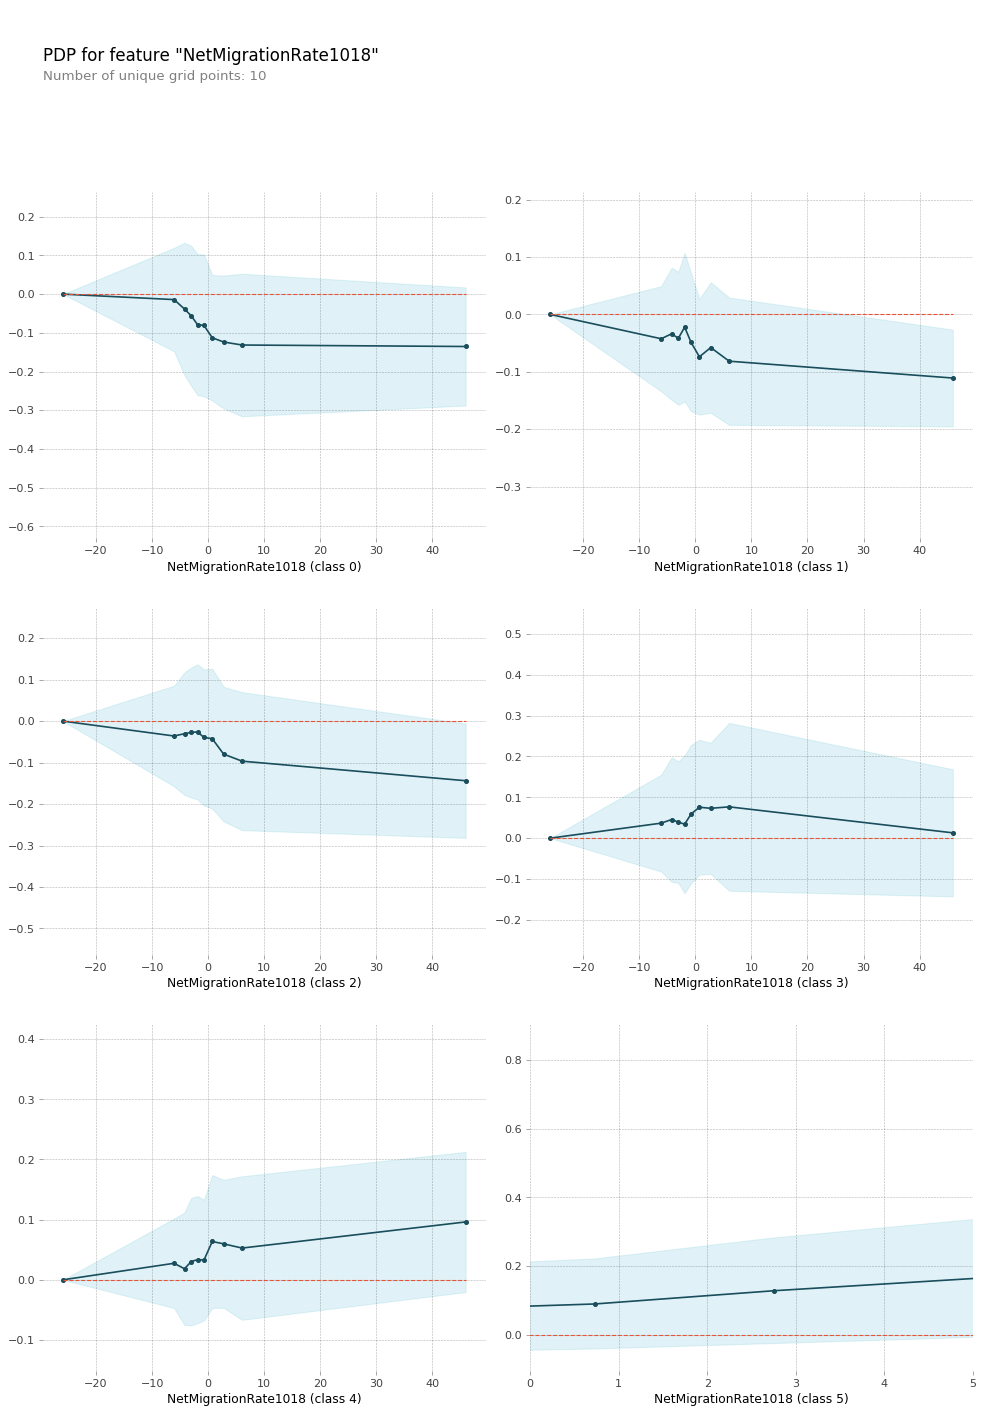

In [0]:
#Plot via Pdpbox

feature = 'NetMigrationRate1018' #options: 'NetMigrationRate1018','Economic Types Type_2015_Update non-overlapping','Low_Education_2015_update','PctVetsPoor','RuralUrbanContinuumCode2013','MedHHInc'
plt.rcParams['figure.dpi'] = 80
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features= X_train.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xlim(0,5);

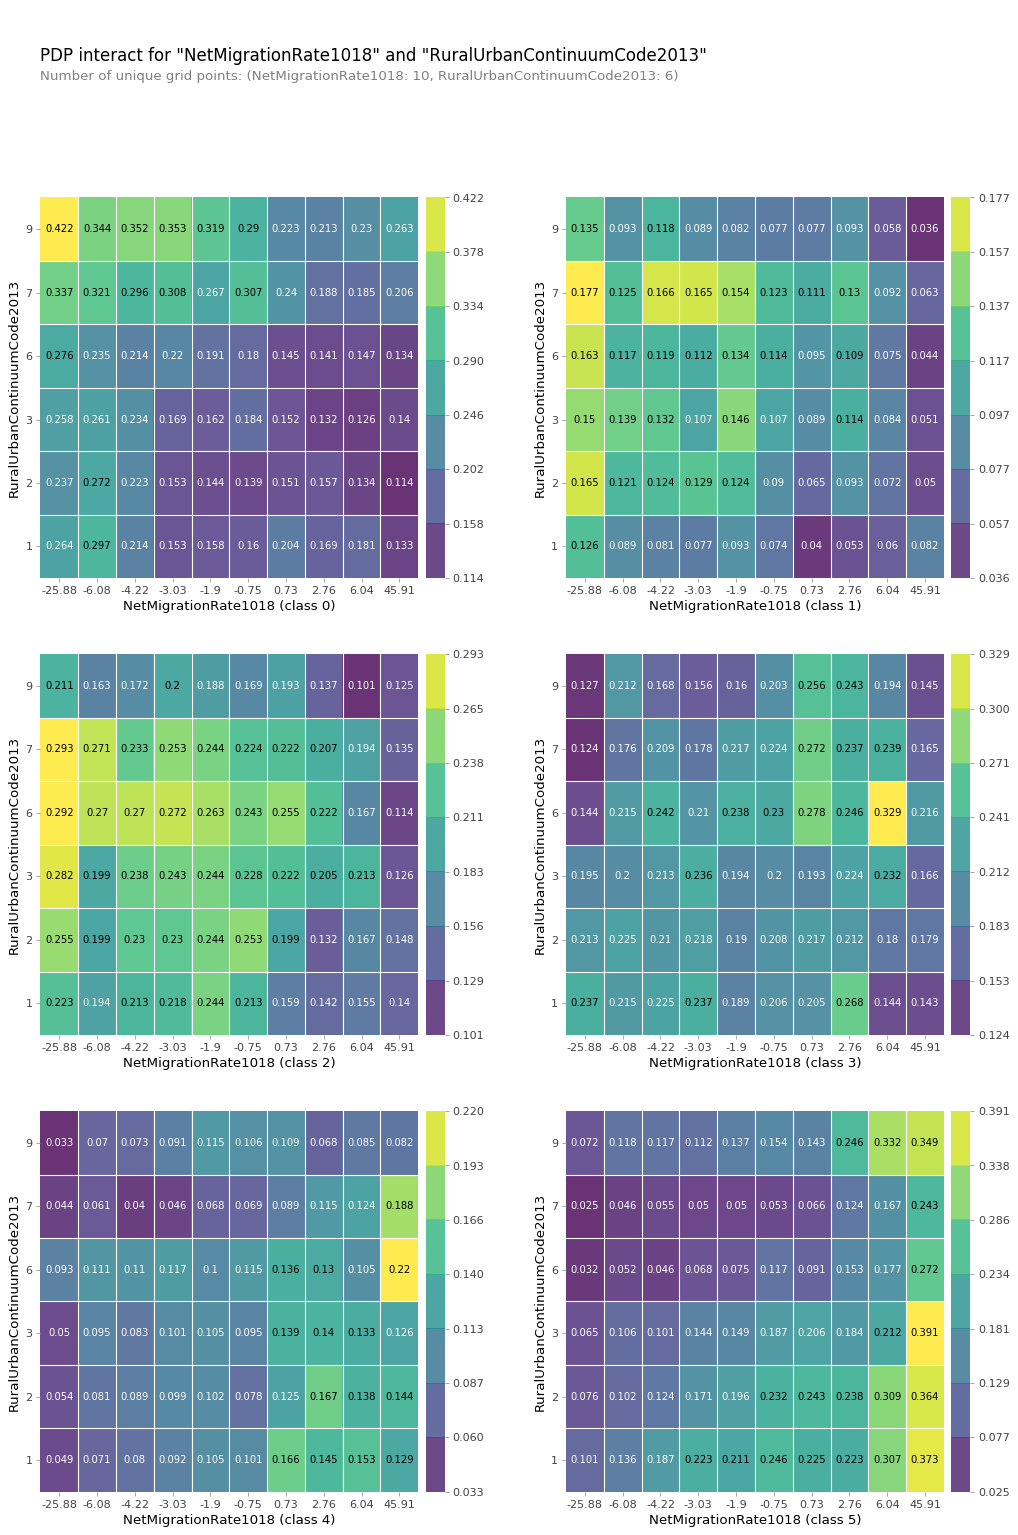

In [0]:
#Two Feat Interaction PDP table
features = ['NetMigrationRate1018', 'RuralUrbanContinuumCode2013'] #options: 'NetMigrationRate1018','Economic Types Type_2015_Update non-overlapping','Low_Education_2015_update','PctVetsPoor','RuralUrbanContinuumCode2013','MedHHInc'


interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# how two feats interact -> affecting the target-value predicted

### Feat Importance: Permutation 

In [0]:
#Permutation method via eli5 lib

# "Importance can be measured by looking at how much the score (eg. accuracy) 
#  decreases when a feature is not available."

In [0]:
# defining a model
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
    )

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# permutation and plot 
permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=2, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

#Interpreting: values at top are most important feats

# "The first number in each row shows how much model performance decreased with a random shuffling.
# The number after the ± measures how performance varied from one-reshuffling to the next.
# You'll occasionally see negative values for permutation importances. In those cases, 
# the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 
# This happens when the feature didn't matter (should have had an importance close to 0), 
# but random chance caused the predictions on shuffled data to be more accurate. 
# This is more common with small datasets, like the one in this example, 
# because there is more room for luck/chance." source:
# https://www.kaggle.com/dansbecker/permutation-importance

#For Blog: sxn. perhaps important to reflect on the ordering here... why some feats may appear to be reversed

# Consider droping all negative values here 

### XG-BOOST
Accuracy score (test): 0.343

In [0]:
# Make a model and fit it to your train set
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
    )
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='multi:softprob', random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
        

In [0]:
#Check accuracy of fitted model, 2 methods shown here

#method1
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

#method2
print(pipeline.score(X_val, y_val)) # same thing

#May repeat for test set
print('Test Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.3238667394866193
0.3238667394866193
Test Accuracy 0.3432642487046632


In [0]:
#Avoiding Overfit via Early Stopping
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((7350, 6), (1831, 6), (7350, 6), (1831, 6))

In [0]:
eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)] 

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=8,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='merror', early_stopping_rounds = 10) #change after early-stop analysis -> see plot below -> b/w epochs 30&60

# classification error is reported w/each training iteration (after each boosted tree is added to the model)
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

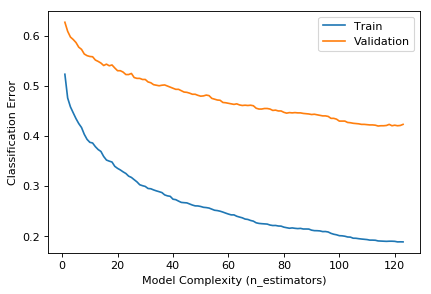

In [0]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.5, 0.61))  # Zoom in
# plt.xlim((.05,40))
plt.legend();

# Iterations
# first: consider removing parameter, allow default to run; train max-out near 90, val near 
# second: train max-out near 90, val near 1000 -> from plot, not the case. 
#         Rather, 90 does appear a decent-enough stop point to avoid overfit. 

### Shapley Values

In [0]:
!pip install shap
import xgboost
import shap
from sklearn.metrics import roc_auc_score

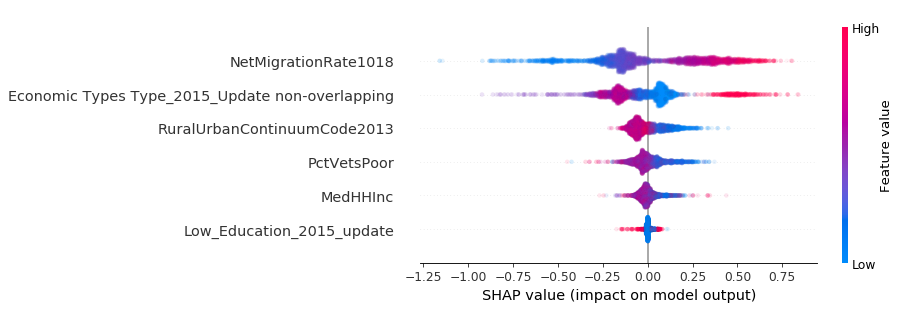

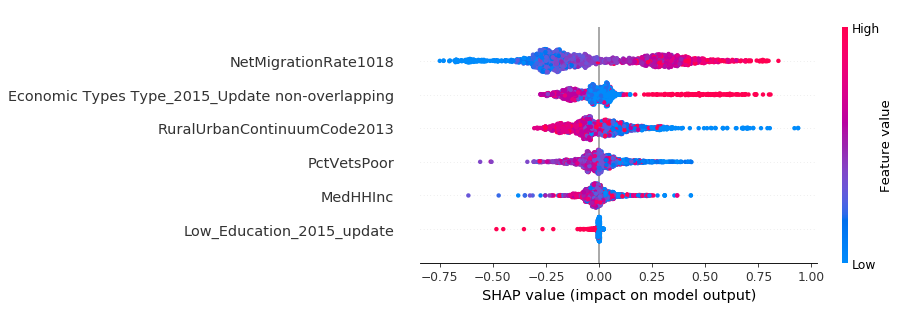

In [0]:
# Make a Shapley values plot

# train set
shap.initjs()

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_encoded, label=y_train), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, alpha = .05)

# validation set
shap.initjs()

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_val, label=y_val), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)


# Notice: output is based on an XGBoost model; recall validation set is .20 the size of train set
# Each dot represents a feature value; https://christophm.github.io/interpretable-ml-book/shapley.html

### ROC-AUC
Alter wrangling fxn for binary class.

In [0]:
#roc & auc for majority class baseline
#works with binary class. types

y_val2 = pd.qcut(y_val, 2, labels = False)
y_pred_proba = np.full_like(y_val2, fill_value=1)
roc_auc_score(y_val2, y_pred_proba)

0.5

In [0]:
#roc/auc for model
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val2, y_pred_proba) #a rather poor score is generated

0.30777012867514225

In [0]:
#Define an all purpose function - using code by Lambda Great Ryan Herr

def set_threshold(y_true, y_pred_proba, threshold=0.5):

    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))

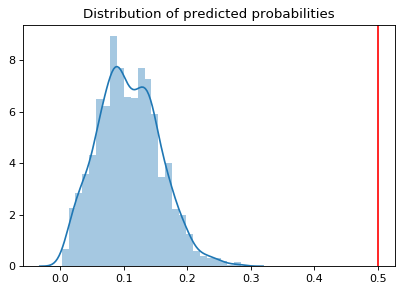

False Positive Rate 0.0
True Positive Rate 0.0


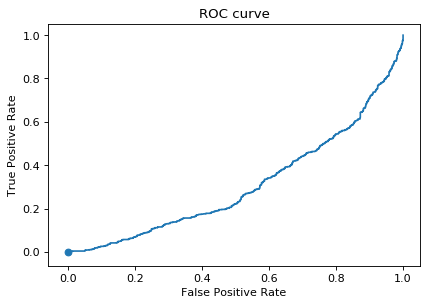

Area under the Receiver Operating Characteristic curve: 0.30777012867514225


In [0]:
set_threshold((y_val2), (y_pred_proba))

### Random Forest + Model Val. Score
Accuracy score (test): 0.790

In [43]:
#pipeline time

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
    )

# Fit on train, score on val

pipeline.fit(X_train,y_train)
print('Validation Accuracy (random-split, top feats)', pipeline.score(X_val,y_val))

pipeline.fit(re_X_train, re_y_train)
print('Validation Accuracy (time-split, top feats)', pipeline.score(re_X_val, re_y_val)) 

# Get accuracy score for Test-set
print('Test Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy (random-split, top feats) 0.6095030038230476
Validation Accuracy (time-split, top feats) 0.5894224077940153
Test Accuracy 0.7858376511226253


In [0]:
#cross validation (optional)

from sklearn.model_selection import cross_val_score
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    )

k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy') #scoring changes w/type of model applied (cluster, class, regression)
print(f'Accuracy Score for {k} folds:', scores)
print('Average Score', np.mean(scores))

Accuracy Score for 5 folds: [0.63747454 0.66530612 0.64193329 0.62899932 0.62899932]
Average Score 0.6405425181362212


### Predictions


In [44]:
#Make a predict function
def predict(migration_rate, economic_type, low_education, veteran_poverty_rate,
               rural_urban_code, median_household_income):
    df = pd.DataFrame(
        data=[[migration_rate, economic_type, low_education, veteran_poverty_rate,
               rural_urban_code, median_household_income]], 
        columns = ['migration_rate', 'economic_type', 'low_education', 'veteran_poverty_rate',
               'rural_urban_code', 'median_household_income']
        )
    
    transformers = make_pipeline(
        ce.OrdinalEncoder(), 
        SimpleImputer(strategy='median')
        )

    X_train_transformed = transformers.fit_transform(X_train)
    X_val_transformed = transformers.transform(X_val)

    model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
    model.fit(X_train_transformed, y_train)

    pred = model.predict(df)[0]
    print(pred)

    return pred

predict(migration_rate=1, economic_type=1, low_education=0, 
          veteran_poverty_rate=1, rural_urban_code=6, median_household_income=1000)


3


3

## Plotting predictions 

### Part I

In [0]:
features,target

(['NetMigrationRate1018',
  'Economic Types Type_2015_Update non-overlapping',
  'Low_Education_2015_update',
  'PctVetsPoor',
  'RuralUrbanContinuumCode2013',
  'MedHHInc'],
 'debt_class')

In [0]:
train.describe()

NetMigrationRate1018  ...   debt_class
count           7350.000000  ...  7350.000000
mean              -0.529839  ...     2.251973
std                5.847054  ...     1.704107
min              -25.880000  ...     0.000000
25%               -3.890000  ...     1.000000
50%               -1.375000  ...     2.000000
75%                2.190000  ...     3.000000
max               45.910000  ...     5.000000

[8 rows x 7 columns]

In [0]:
train.median() #or just refer to 50% entries from train.describe() above

NetMigrationRate1018                                  -1.3750
Economic Types Type_2015_Update non-overlapping        1.0000
Low_Education_2015_update                              0.0000
PctVetsPoor                                            9.7444
RuralUrbanContinuumCode2013                            6.0000
MedHHInc                                           47813.0000
debt_class                                             2.0000
dtype: float64

In [0]:
#Control using medians
predict(migration_rate=-1.3750, economic_type=1, low_education=0, 
          veteran_poverty_rate=9.7444, rural_urban_code=6, median_household_income=47813) 

#testing output returns a 2 - the median value of y_train

In [0]:
#Predict y using high,med,and lows of each feature, controling for other features

# changing feat1
predict(migration_rate=10000000, economic_type=1, low_education=0, 
          veteran_poverty_rate=9.7444, rural_urban_code=6, median_household_income=47813)
# >>(2,2,4)

# changing feat2
predict(migration_rate=-1.3750, economic_type=5, low_education=0, 
          veteran_poverty_rate=9.7444, rural_urban_code=6, median_household_income=47813)
# >>(2,2,2)

# changing feat3
predict(migration_rate=-1.3750, economic_type=1, low_education=1, 
          veteran_poverty_rate=9.7444, rural_urban_code=6, median_household_income=47813)
# >>(2,2,2)

# changing feat4
predict(migration_rate=-1.3750, economic_type=1, low_education=0, 
          veteran_poverty_rate=75, rural_urban_code=6, median_household_income=47813)
# >>(2,2,0)

# changing feat5
predict(migration_rate=-1.3750, economic_type=1, low_education=0, 
          veteran_poverty_rate=9.7444, rural_urban_code=9, median_household_income=47813)
# >>(5,2,0)

# changing feat6
predict(migration_rate=-1.3750, economic_type=1, low_education=0, 
          veteran_poverty_rate=9.7444, rural_urban_code=6, median_household_income=69937.000000)
# >>(0,2,3)

In [0]:
#Optional: Make a df of predicted values -> for passage through a predict function
# data = {'Migration Rate': ['min','median','max'],'Debt Class':[2,2,4]}
# df1 = pd.DataFrame(data)
# data = {'Economic Type': ['min','median','max'],'Debt Class':[2,2,4]}
# df2 = pd.DataFrame(data)
# data = {'Low Education': ['min','median','max'],'Debt Class':[2,2,2]}
# df3 = pd.DataFrame(data)
# data = {'Veteran Poverty Rate': ['min','median','max'],'Debt Class':[2,2,0]}
# df4 = pd.DataFrame(data)
# data = {'Rural-Urban Code': ['min','median','max'],'Debt Class':[5,2,0]}
# df5 = pd.DataFrame(data)
# data = {'Median Household Income': ['min','median','max'],'Debt Class':[0,2,3]}
# df6 = pd.DataFrame(data)

In [0]:
#Alternative method: Combine into one graph/plot/chart
import plotly.graph_objects as go

x_qualities = ['Low','Moderate','High'] 

fig = go.Figure()
fig.add_trace(go.Bar(x=x_qualities,
                y=[2,2,4],
                name='Migration Rate',
                marker_color='rgb(30, 90, 110)'
                ))
fig.add_trace(go.Bar(x=x_qualities,
                y=[2,2,4],
                name='Economic Type',
                marker_color='rgb(40, 70, 100)'
                ))
fig.add_trace(go.Bar(x=x_qualities,
                y=[2,2,2],
                name='Low Education',
                marker_color='rgb(50, 50, 100)'
                ))
fig.add_trace(go.Bar(x=x_qualities,
                y=[2,2,0],
                name='Veteran Poverty Rate',
                marker_color='rgb(60, 30, 100)'
                ))
fig.add_trace(go.Bar(x=x_qualities,
                y=[5,2,0],
                name='Rural-Urban Continuum Code',
                marker_color='rgb(250, 187, 85)'
                ))
fig.add_trace(go.Bar(x=x_qualities,
                y=[0,2,3],
                name='Median Household Income',
                marker_color='rgb(247, 58, 45)'
                ))

fig.update_layout(
    title='Few Controlled Feature Changes Impact Predicted Debt Class',
    xaxis=dict(
        title = 'Input Values',
        titlefont_size=16,
        tickfont_size=14
    ),
    yaxis=dict(
        title='Debt Class',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

# The takeaway: Rural-Urban Continuum Code and Median Household Income appear to most directly 
#  impact change in Debt Class, all other features being held constant

In [0]:
train['RuralUrbanContinuumCode2013'].value_counts()

6.0    1486
7.0    1070
9.0    1046
3.0     902
2.0     878
1.0     672
8.0     545
4.0     541
5.0     210
Name: RuralUrbanContinuumCode2013, dtype: int64

In [0]:
# Now a brief focus on these two features 
random_list_1 = np.random.randint(low=1, high=10, size=1000)
random_list_2 = np.random.randint(low=14000, high=78000, size=1000)

In [0]:
e =np.array(random_list_1)
f =np.array(random_list_2)

In [0]:
# set up X-matrices for each variable feature

df_random1 = pd.DataFrame({'starter':e})
df_random1['migration_rate'] = -1.375
df_random1['economic_type'] = 1
df_random1['low_education'] = 0
df_random1['veteran_poverty_rate'] = 9.7444
df_random1['rural_urban_code'] = e
df_random1['median_household_income'] = 47813
df_random1 = df_random1.drop('starter', axis=1)
df_random1.tail(3)

df_random2 = pd.DataFrame({'starter':e})
df_random2['migration_rate'] = -1.375
df_random2['economic_type'] = 1
df_random2['low_education'] = 0
df_random2['veteran_poverty_rate'] = 9.7444
df_random2['rural_urban_code'] = 6
df_random2['median_household_income'] = f
df_random2 = df_random2.drop('starter', axis=1)
df_random2.tail(3)

#recall label names: migration_rate, economic_type, low_education, veteran_poverty_rate, rural_urban_code, median_household_income

migration_rate  economic_type  ...  rural_urban_code  median_household_income
997          -1.375              1  ...                 6                    57887
998          -1.375              1  ...                 6                    51333
999          -1.375              1  ...                 6                    77941

[3 rows x 6 columns]

In [0]:
df_random1.shape, df_random2.shape

((1000, 6), (1000, 6))

In [0]:
# Predict the y-values
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
    )
pipeline.fit(X_train,y_train)

y_pred1 = pipeline.predict(df_random1) #array-type output
y_pred2 = pipeline.predict(df_random2) 

# add to dataframe
df_prediction1 = df_random1.copy()
df_prediction1['debt_class'] = y_pred1

df_prediction2 = df_random2.copy()
df_prediction2['debt_class'] = y_pred2

df_prediction1.head()

migration_rate  economic_type  ...  median_household_income  debt_class
0          -1.375              1  ...                    47813           3
1          -1.375              1  ...                    47813           5
2          -1.375              1  ...                    47813           5
3          -1.375              1  ...                    47813           5
4          -1.375              1  ...                    47813           2

[5 rows x 7 columns]

### Part II

In [0]:
df_prediction1['rural_urban_code'].value_counts()

1    121
9    119
2    119
3    117
4    115
7    113
6    106
8    105
5     85
Name: rural_urban_code, dtype: int64

In [0]:
df_prediction2['median_household_income'] = pd.cut(df_prediction2['median_household_income'],
                                                  9, labels = [1,2,3,4,5,6,7,8,9])

In [0]:
df_prediction2.head()

migration_rate  economic_type  ...  median_household_income  debt_class
0          -1.375              1  ...                        5           3
1          -1.375              1  ...                        1           0
2          -1.375              1  ...                        7           3
3          -1.375              1  ...                        2           0
4          -1.375              1  ...                        6           3

[5 rows x 7 columns]

In [0]:
#Get finer points/resolution for rural_urban_code and median_household_income,
# taking average where multiple outputs 

dt = df_prediction1.query('rural_urban_code == 9') 
# y = [5, 5, 5, 2, 0, 0, 0, 3, 0] 

dt2 = df_prediction2.query('median_household_income == 5')
# y = [0,0,0,0,0.833,2.111,2.240,3.052,2.0] 

print(dt)
#print(dt2)

In [0]:
# insert finer y-points in code for feature-specific bar plot
#  First, for rural_urban_code
x_qualities = [1,2,3,4,5,6,7,8,9]

fig = go.Figure()
fig.add_trace(go.Bar(x=x_qualities,
                y=[5, 5, 5, 2, 0, 0, 0, 3, 0],
                name='Rural-Urban Code',
                marker_color='rgb(250, 187, 85)'
                ))

fig.update_layout(
    title='Debt Class Invariably High In Metropolitan Counties',
    xaxis=dict(
        title = 'Rural-Urban Continuum Code',
        titlefont_size=16,
        tickfont_size=14
    ),
    yaxis=dict(
        title='Debt Class',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

#for documentation of Rural-Urban Continuum Codes: https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/

In [0]:
#  Second, for median_household_income
x_qualities = ['<$21000','$21000-28000','$28000-35000','$35000-42000',
               '$42000-50000','$50000-57000','$57000-64000','$64000-71000','$71000-78000']

fig = go.Figure()
fig.add_trace(go.Bar(x=x_qualities,
                y=[0,0,0,0,0.833,2.111,2.240,3.052,2.0],
                name='Rural-Urban Code',
                marker_color='rgb(247, 58, 45)'
                ))

fig.update_layout(
    title='Wealthier Counties Hold Greater Debt',
    xaxis=dict(
        title = 'Median Household Income (USD)',
        titlefont_size=16,
        tickfont_size=14, 
    ),
    yaxis=dict(
        title='Debt Class',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)

fig.update_xaxes(tickangle=-30)

fig.show();

In [0]:
# with a respectable degree of confidence (approx. 65%, I can arrive at the conclusions defined in the two previous graphs/plots.
# These conclusions control for potential confounding variables through use of the prediction model - an endeavor which wouldn't 
# be feasible undertaking by hand. 

### Part III
*Interactive* plots via plotly

In [45]:
#Recall the predict function...
def predict(migration_rate, economic_type, low_education, veteran_poverty_rate,
               rural_urban_code, median_household_income):
    df = pd.DataFrame(
        data=[[migration_rate, economic_type, low_education, veteran_poverty_rate,
               rural_urban_code, median_household_income]], 
        columns = ['migration_rate', 'economic_type', 'low_education', 'veteran_poverty_rate',
               'rural_urban_code', 'median_household_income']
        )
    
    transformers = make_pipeline(
        ce.OrdinalEncoder(), 
        SimpleImputer(strategy='median')
        )

    X_train_transformed = transformers.fit_transform(X_train)
    X_val_transformed = transformers.transform(X_val)

    model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
    model.fit(X_train_transformed, y_train)

    pred = model.predict(df)[0]
    print(pred)

    return pred

#run test
predict(migration_rate=1, economic_type=1, low_education=0, 
          veteran_poverty_rate=1, rural_urban_code=6, median_household_income=1000)

3


3

In [51]:
train.describe()

NetMigrationRate1018  ...   debt_class
count           7350.000000  ...  7350.000000
mean              -0.529839  ...     2.251973
std                5.847054  ...     1.704107
min              -25.880000  ...     0.000000
25%               -3.890000  ...     1.000000
50%               -1.375000  ...     2.000000
75%                2.190000  ...     3.000000
max               45.910000  ...     5.000000

[8 rows x 7 columns]

In [113]:
import ipywidgets as ip
from ipywidgets import interact,widgets,interact_manual,IntSlider, FloatSlider
deviner = ip.interact(predict, migration_rate = FloatSlider(value=-1.38, min=-100, max=100, step=.01, description='Migration Rate:'), 
            economic_type = IntSlider(value=1, min=0, max=5, step=1, description='Economic Type:'), 
            low_education=IntSlider(value=0,min=0, max=1, step=1, description='Low Education:'),
            veteran_poverty_rate = FloatSlider(value=9.74, min=0, max=100, step=.01, description='Veteran Poverty Rate:'), 
            rural_urban_code=IntSlider(value=6, min=1, max=9, step=1, description='Rural-Urban Continuum Code:'), 
            median_household_income=IntSlider(value=47800, min=0, max=100000, step=100, description='Median Household Income:'));


interactive(children=(FloatSlider(value=-1.38, description='Migration Rate:', min=-100.0, step=0.01), IntSlide…

<function __main__.predict>

### scraps

In [129]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(1, 11, 1):
    fig.add_trace(
        go.Bar(
            visible=False,
            x = ['Feature'],
            y = [predict(migration_rate=step, economic_type=1, low_education=0, 
                veteran_poverty_rate=1, rural_urban_code=6, median_household_income=1000)
                ]))

# Make 10th trace visible
fig.data[1].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
    )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=12,
    currentvalue={"prefix": "Input value (Rural-Urban Continuum Code): "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Predict The Debt-Class',
                  yaxis=go.layout.YAxis(
                    title=go.layout.yaxis.Title(
                    text="Debt-Class"))) 
                    
fig.show()

3
3
3
0
0
0
0
0
0
0


In [86]:
# Make an interactive plot via plotly

# make a canvas
fig = go.Figure()

# devfine axes properties
fig.update_xaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
)

fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
)

# add a shape
fig.update_layout(
    shapes=[
        go.layout.Shape(
            opacity=0.3,
            xref="x",
            yref="y",
            fillcolor="blue",
#             x0=0,
#             y0=0,
#             x1=2,
#             y1=2,
            type="circle",
            line_color="blue",
            layer="below"
        )])

# Update figure dimensions
fig.update_layout(
    margin=dict(
        l=20,
        r=20,
        b=50
    ),
    height=500,
    width=500,
    plot_bgcolor="white"
)

fig.show()


In [0]:
# make a color function 

## Header Plot

In [142]:
!pip install plotly-geo==1.0.0

In [143]:
dfv.head(2)

year  qtr  FIPS   low  ...  BohShareSE  CCShareRME  BohShareRME  metro03
0  2013    1  1001  3.46  ...     0.00168     0.02079      0.00277        1
1  2013    2  1001  3.46  ...     0.00168     0.02079      0.00277        1

[2 rows x 55 columns]

In [0]:
!pip install plotly-geo==1.0.0
import plotly.figure_factory as ff

In [155]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

import plotly.graph_objects as go

fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=df.fips, z=dfv.low,
                                    colorscale="Viridis", zmin=0, zmax=5,
                                    marker_opacity=0.8, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()